In [48]:
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import pandas as pd

### First look at the dataset

In [49]:
dfHOrg = pd.read_csv('housing.csv')
dfHOrg.info()
dfHOrg.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [50]:
dfH = dfHOrg.dropna().copy()
dfH.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


* Rows where there is missing data in the total_bedrooms column is removed

### Some histograms to assess the data

Text(0.5, 1.0, '# of households by ocean_proximity')

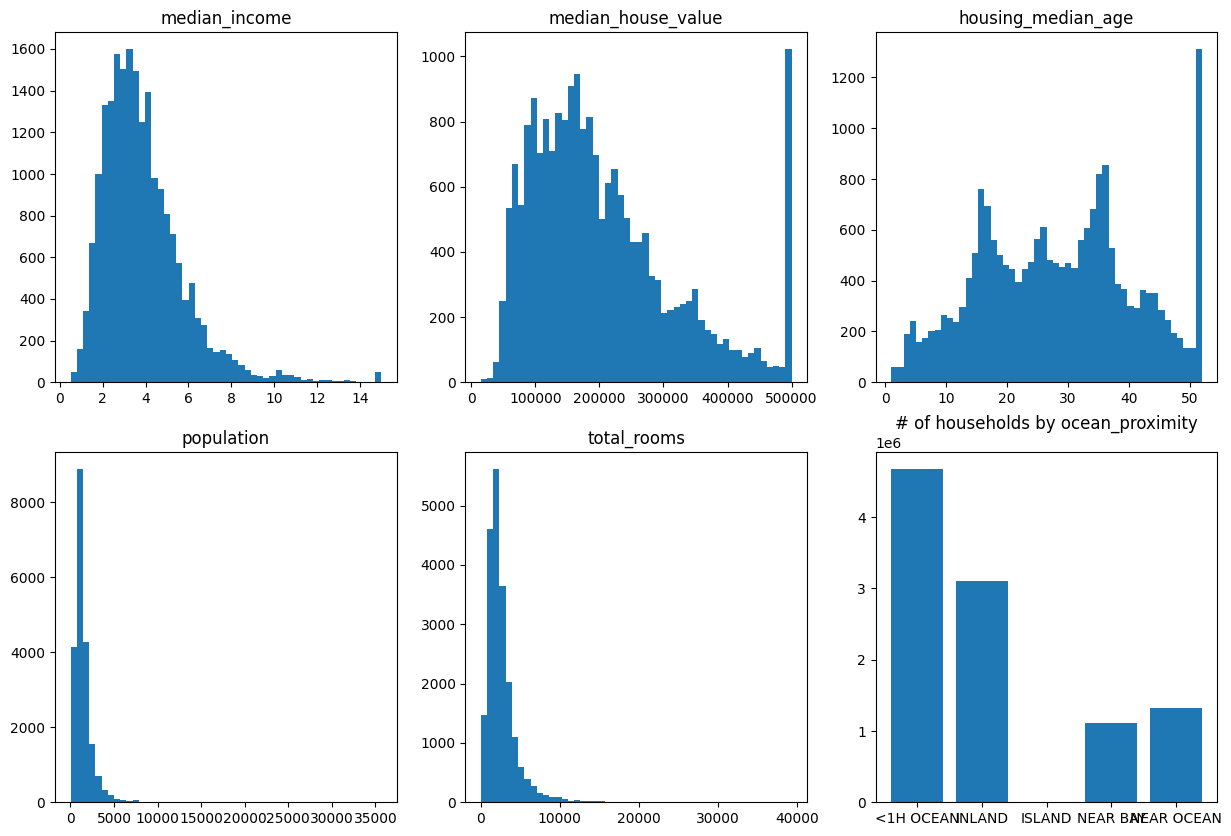

In [51]:
# Create dictionary of the number of households in each category of 'ocean_proximity' for bar chart
diOP = dfH.groupby(['ocean_proximity']).sum().to_dict()['households']

fig, ax = plt.subplots(2,3,figsize=(15,10))

ax[0,0].hist(dfH['median_income'], bins=50)
ax[0,0].set_title('median_income')
ax[0,1].hist(dfH['median_house_value'], bins=50)
ax[0,1].set_title('median_house_value')
ax[0,2].hist(dfH['housing_median_age'], bins=50)
ax[0,2].set_title('housing_median_age')
ax[1,0].hist(dfH['population'], bins=50)
ax[1,0].set_title('population')
ax[1,1].hist(dfH['total_rooms'], bins=50)
ax[1,1].set_title('total_rooms')
ax[1,2].bar(x=list(diOP.keys()), height=list(diOP.values()))
ax[1,2].set_title('# of households by ocean_proximity')


#### Analysis
* There are some issues with median_house_value and housing_median_age in regards to the upper limit. Maybe median_house_values over 500 000 and housing_median_age over ~50 years all are recorded with a max value. This can get some unforseen results in an AI model.
* Population in most areas is small, but in some areas it is massive. The same i true for the number of rooms in areas. This is something to keep an eye on.
* Of the over 10 million households, a little over 3 million is situated inland. The rest is situated by the ocean, in the bay area (by the ocean) or in close proximity to the ocean.

### Some further analysis

Text(0, 0.5, 'Median house value')

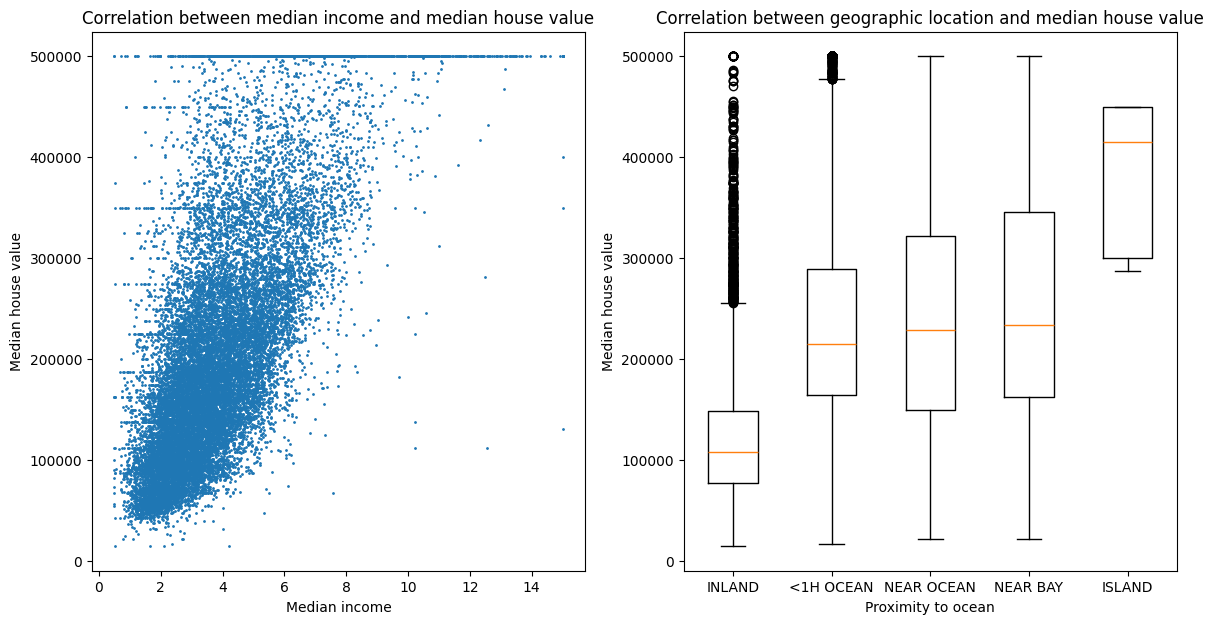

In [52]:
fig, ax = plt.subplots(1,2,figsize=(14,7))

inland = dfH.loc[dfH['ocean_proximity'] == 'INLAND']['median_house_value']
near_ocean = dfH.loc[dfH['ocean_proximity'] == 'NEAR OCEAN']['median_house_value']
near_bay = dfH.loc[dfH['ocean_proximity'] == 'NEAR BAY']['median_house_value']
ocean_1h = dfH.loc[dfH['ocean_proximity'] == '<1H OCEAN']['median_house_value']
island = dfH.loc[dfH['ocean_proximity'] == 'ISLAND']['median_house_value']

ax[0].scatter(dfH['median_income'], dfH['median_house_value'], s=1)
ax[0].set_title('Correlation between median income and median house value')
ax[0].set_xlabel('Median income')
ax[0].set_ylabel('Median house value')
ax[1].boxplot([inland,ocean_1h,near_ocean,near_bay,island])
ax[1].set_xticklabels(['INLAND','<1H OCEAN','NEAR OCEAN','NEAR BAY','ISLAND'])
ax[1].set_title('Correlation between geographic location and median house value')
ax[1].set_xlabel('Proximity to ocean')
ax[1].set_ylabel('Median house value')


#### Analysis
* There seems to be some correlation between median income and median house value.
* Inland houses generally has a lower value than houses near the ocean.
* In both plots the large amounts of areas where the median house value is maxed out at 500 000 can be seen in both plots.

### Some geographic plots
#### What does 'ocean proximity' mean?
* In the next plot the inland areas are marked with a black dot. The areas in the other groups (with a closer proximit to the ocean) has colored dots.

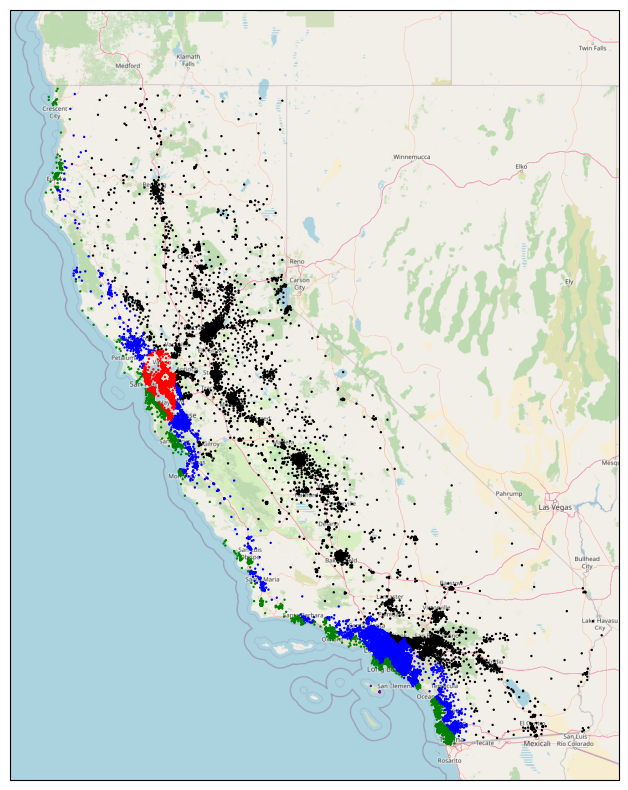

In [53]:
dfH['colors'] = 'black'
dfH.loc[dfH['ocean_proximity'] == 'NEAR BAY', 'colors'] = 'red'
dfH.loc[dfH['ocean_proximity'] == 'NEAR OCEAN', 'colors'] = 'green'
dfH.loc[dfH['ocean_proximity'] == '<1H OCEAN', 'colors'] = 'blue'
dfH.loc[dfH['ocean_proximity'] == 'ISLAND', 'colors'] = 'purple'

request = cimgt.OSM()

extent = [-125 , -114, 32, 43]

fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': request.crs})
ax.set_extent(extent)
ax.add_image(request, 7)

ax.scatter(dfH['longitude'], dfH['latitude'], s=0.5, c=dfH['colors'], transform=ccrs.PlateCarree())


#### Median house value on a map
* The areas with the higest median house values in red. The scale then goes orange, green, blue and purple with falling median house values.

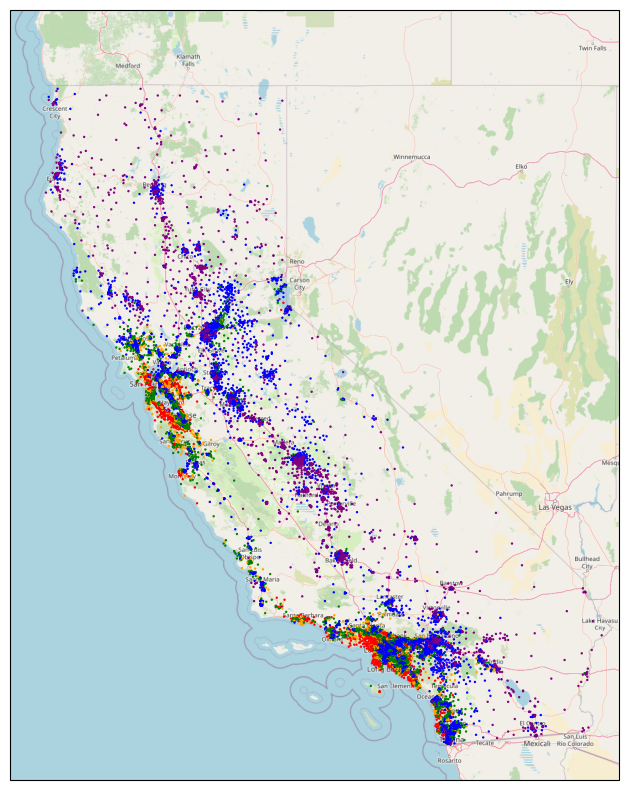

In [54]:
dfH['colors'] = 'red'
dfH.loc[dfH['median_house_value'] < 400000, 'colors'] = 'orange'
dfH.loc[dfH['median_house_value'] < 300000, 'colors'] = 'green'
dfH.loc[dfH['median_house_value'] < 200000, 'colors'] = 'blue'
dfH.loc[dfH['median_house_value'] < 100000, 'colors'] = 'purple'

request = cimgt.OSM()

extent = [-125 , -114, 32, 43]

fig, ax = plt.subplots(figsize=(10,10), subplot_kw={'projection': request.crs})
ax.set_extent(extent)
ax.add_image(request, 7)

ax.scatter(dfH['longitude'], dfH['latitude'], s=0.5, c=dfH['colors'], transform=ccrs.PlateCarree())

* The remote inland areas has the lowest median house values.

### Självutvärdering
1. Rent programmeringsmässigt var det inte så utmanande. Lite utmanande att förstå vad som är viktigt att titta på i ett dataset inför att använda det i AI-modelleringen. Men jag tänker att det är något som kommer att klarna mer och mer när vi går in i nästa delkurs. Jag har en del erfarenhet av python och pandas, men mindre med numpy och matplotlib, så det har varit en nyttig del att fräscha upp den delen.
2. Jag vill nog gärna tro att det jag gjort ger ett godkänt betyg.
3. Bra med inspelningarna av lektionerna eftersom jag hittills haft en del jobbgrejer som krockat. Men jag har bokat upp i min kalender för att få så få jobbaktiviteter som möjligt på fredagseftermiddagarna framöver. Känns som om det är viktigt att vara med nu när nästa delkurs drar igång.